In [67]:
import pyspark
from azure.storage.blob import BlobServiceClient
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DoubleType, IntegerType, LongType
from pyspark.sql.functions import count,lit, when,col,expr, udf, avg,to_date,broadcast,regexp_replace,last,lpad,concat_ws,date_format,year,month
from pyspark.sql import Window
import sys
from pyspark import SparkContext
import pyspark.sql 

import pandas as pd
import matplotlib.pyplot as plt



STORAGEACCOUNTURL = "https://trainingbatchaccount.blob.core.windows.net"
STORAGEACCOUNTKEY = "2QPPHsAtQ8/fh33VE7wqg/ZaeJoxdq/pnevAEmCh0n32tC5eXa8dTEEwMHdD9Ff5k1/wVh97aubqgKzQSwOLnQ=="
CONTAINERNAME = "datasets"
# HOSPITALIZATION = "economy.csv"
# INDEX = "index.csv"


spark = SparkSession.builder.appName('azure').getOrCreate()
spark.conf.set(
        "fs.azure.account.key.trainingbatchaccount.blob.core.windows.net",
        STORAGEACCOUNTKEY
    
)

#-----------------------------Schema for hospitalizations dataset-------------------------------

hospitalizations_schema = StructType([StructField("date",StringType(), True),\
    StructField("location_key",StringType(), True),\
    StructField("new_hospitalized_patients", IntegerType(), True),\
    StructField("cumulative_hospitalized_patients", IntegerType(), True),\
    StructField("current_hospitalized_patients", IntegerType(), True),\
    StructField("new_intensive_care_patients", IntegerType(), True),\
    StructField("cumulative_intensive_care_patients", IntegerType(), True),\
    StructField("current_intensive_care_patients", IntegerType(), True),\
    StructField("new_ventilator_patients", StringType(), True),\
    StructField("cumulative_ventilator_patients", StringType(), True),\
    StructField("current_ventilator_patients", IntegerType(), True)])

#-----------------------------Schema for vaccination dataset-------------------------------  

vaccination_schema = StructType([StructField("date",StringType(), True),\
    StructField("location_key",StringType(), True),\
    StructField("new_persons_vaccinated", IntegerType(), True),\
    StructField("cumulative_persons_vaccinated", IntegerType(), True),\
    StructField("new_persons_fully_vaccinated", IntegerType(), True),\
    StructField("cumulative_persons_fully_vaccinated", IntegerType(), True),\
    StructField("new_vaccine_doses_administered", IntegerType(), True),\
    StructField("cumulative_vaccine_doses_administered", LongType(), True),\
    StructField("new_persons_vaccinated_pfizer", IntegerType(), True),\
    StructField("cumulative_persons_vaccinated_pfizer", IntegerType(), True),\
    StructField("new_persons_fully_vaccinated_pfizer", IntegerType(), True),\
    StructField("cumulative_persons_fully_vaccinated_pfizer", IntegerType(), True),\
    StructField("new_vaccine_doses_administered_pfizer", IntegerType(), True),\
    StructField("cumulative_vaccine_doses_administered_pfizer", IntegerType(), True),\
    StructField("new_persons_vaccinated_moderna", IntegerType(), True),\
    StructField("cumulative_persons_vaccinated_moderna", IntegerType(), True),\
    StructField("new_persons_fully_vaccinated_moderna", IntegerType(), True),\
    StructField("cumulative_persons_fully_vaccinated_moderna", IntegerType(), True),\
    StructField("new_vaccine_doses_administered_moderna", IntegerType(), True),\
    StructField("cumulative_vaccine_doses_administered_moderna", IntegerType(), True),\
    StructField("new_persons_vaccinated_janssen", IntegerType(), True),\
    StructField("cumulative_persons_vaccinated_janssen", IntegerType(), True),\
    StructField("new_persons_fully_vaccinated_janssen", IntegerType(), True),\
    StructField("cumulative_persons_fully_vaccinated_janssen", IntegerType(), True),\
    StructField("new_vaccine_doses_administered_janssen", IntegerType(), True),\
    StructField("cumulative_vaccine_doses_administered_janssen", IntegerType(), True),\
    StructField("new_persons_vaccinated_sinovac", IntegerType(), True),\
    StructField("total_persons_vaccinated_sinovac", IntegerType(), True),\
    StructField("new_persons_fully_vaccinated_sinovac", StringType(), True),\
    StructField("total_persons_fully_vaccinated_sinovac", StringType(), True),\
    StructField("new_vaccine_doses_administered_sinovac", StringType(), True),\
    StructField("total_vaccine_doses_administered_sinovac", StringType(), True)])
  #-----------------------------Schema for epidemiology dataset-------------------------------

epidemiology_schema = StructType([StructField("date",StringType(), True),\
    StructField("location_key",StringType(), True),\
    StructField("new_confirmed", IntegerType(), True),\
    StructField("new_deceased", IntegerType(), True),\
    StructField("new_recovered", IntegerType(), True),\
    StructField("new_tested", IntegerType(), True),\
    StructField("cumulative_confirmed", IntegerType(), True),\
    StructField("cumulative_deceased", IntegerType(), True),\
    StructField("cumulative_recovered", IntegerType(), True),\
    StructField("cumulative_tested", IntegerType(), True)])

  

hosp_df = spark.read.format('csv').option('header',True).schema(hospitalizations_schema).load("wasbs://datasets@trainingbatchaccount.blob.core.windows.net/hospitalizations.csv")
vacc_df = spark.read.format('csv').option('header',True).schema(vaccination_schema).load("wasbs://datasets@trainingbatchaccount.blob.core.windows.net/vaccinations.csv")
epi_df = spark.read.format('csv').option('header',True).schema(epidemiology_schema).load("wasbs://datasets@trainingbatchaccount.blob.core.windows.net/epidemiology.csv")



In [68]:
# to find shape of dataframe 
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkShape

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [69]:
from pyspark.sql import SparkSession
import functools
 

In [70]:
#---------------------------------Opening hospitalization dataset and cleaning it----------------

hosp_df = hosp_df.withColumn('Date',to_date(hosp_df['date'],'dd-MM-yyyy'))
#fill empty values with zero
hosp_df = hosp_df.fillna(value = 0, subset = ['new_hospitalized_patients','current_hospitalized_patients','current_intensive_care_patients','new_ventilator_patients','cumulative_ventilator_patients','current_ventilator_patients'])
#drop unwanted column
hosp_df = hosp_df.drop('cumulative_ventilator_patients','new_ventilator_patients')
hosp_df = hosp_df.where((hosp_df.location_key == 'AR')&(hosp_df.Date >= '2021-01-01')&(hosp_df.Date <= '2021-12-31'))


In [71]:
 #---------------------------------Opening epidemology dataset and cleaning it----------------
    
# epi_df = epi_df.withColumn('date',to_date(epi_df['date'],format='yyyy-mm-dd'))
# epi_df = epi_df.na.fill(value=0)


#correct date format
epi_df = epi_df.withColumn('Date',to_date(epi_df['date'],format='yyyy-MM-dd'))
epi_df = epi_df.na.fill(value=0)
# vacc_df = vacc_df.withColumn('Date_1',(vacc_df['Date']))
# vacc_df = vacc_df.withColumn("Date_string",vacc_df.Date.cast(StringType()))
epi_df = epi_df.where((epi_df.location_key == 'AR')&(epi_df.Date >= '2021-01-01')&(epi_df.Date <= '2021-12-31'))
epi_df = epi_df.drop('location_key')

In [72]:
epi_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- new_confirmed: integer (nullable = true)
 |-- new_deceased: integer (nullable = true)
 |-- new_recovered: integer (nullable = true)
 |-- new_tested: integer (nullable = true)
 |-- cumulative_confirmed: integer (nullable = true)
 |-- cumulative_deceased: integer (nullable = true)
 |-- cumulative_recovered: integer (nullable = true)
 |-- cumulative_tested: integer (nullable = true)



In [73]:
 #---------------------------------Opening vaccination dataset and cleaning it----------------
    
#selecting needed columns only
vacc_df = vacc_df.select("date","location_key","new_persons_vaccinated","cumulative_persons_vaccinated","new_persons_fully_vaccinated","cumulative_persons_fully_vaccinated","new_vaccine_doses_administered","cumulative_vaccine_doses_administered")

#Drop rows if all the values are null
vacc_df = vacc_df.na.drop(subset=["new_persons_vaccinated","cumulative_persons_vaccinated","new_persons_fully_vaccinated","cumulative_persons_fully_vaccinated","new_vaccine_doses_administered","cumulative_vaccine_doses_administered"] ,how="all")

#fill cumulative value with previous field value (Forward Fill)
vacc_df = vacc_df.withColumn("cumulative_persons_vaccinated", last('cumulative_persons_vaccinated', True).over(Window.partitionBy('location_key').rowsBetween(-sys.maxsize, 0)))
vacc_df = vacc_df.withColumn("cumulative_persons_fully_vaccinated",last('cumulative_persons_fully_vaccinated', True).over(Window.partitionBy('location_key').rowsBetween(-sys.maxsize, 0)))
vacc_df = vacc_df.withColumn("cumulative_vaccine_doses_administered",last('cumulative_vaccine_doses_administered', True).over(Window.partitionBy('location_key').rowsBetween(-sys.maxsize, 0)))

#replace null with zero
vacc_df = vacc_df.na.fill(value=0)

#correct date format
vacc_df = vacc_df.withColumn('Date',to_date(vacc_df['Date'],format='yyyy-MM-dd'))
# vacc_df = vacc_df.withColumn('Date_1',(vacc_df['Date']))
# vacc_df = vacc_df.withColumn("Date_string",vacc_df.Date.cast(StringType()))
vacc_df = vacc_df.where((vacc_df.location_key == 'AR')&(vacc_df.Date >= '2021-01-01')&(vacc_df.Date <= '2021-12-31'))
#  hosp_df.where((hosp_df.location_key == 'AR')&(hosp_df.Date >= '2021-01-01')&(hosp_df.Date <= '2021-12-31'))
vacc_df = vacc_df.drop('location_key')
    

In [74]:
hosp_df.printSchema()
vacc_df.printSchema()
epi_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- location_key: string (nullable = true)
 |-- new_hospitalized_patients: integer (nullable = true)
 |-- cumulative_hospitalized_patients: integer (nullable = true)
 |-- current_hospitalized_patients: integer (nullable = true)
 |-- new_intensive_care_patients: integer (nullable = true)
 |-- cumulative_intensive_care_patients: integer (nullable = true)
 |-- current_intensive_care_patients: integer (nullable = true)
 |-- current_ventilator_patients: integer (nullable = true)

root
 |-- Date: date (nullable = true)
 |-- new_persons_vaccinated: integer (nullable = true)
 |-- cumulative_persons_vaccinated: integer (nullable = true)
 |-- new_persons_fully_vaccinated: integer (nullable = true)
 |-- cumulative_persons_fully_vaccinated: integer (nullable = true)
 |-- new_vaccine_doses_administered: integer (nullable = true)
 |-- cumulative_vaccine_doses_administered: long (nullable = true)

root
 |-- Date: date (nullable = true)
 |-- new_confirmed: integ

In [90]:
# joining 
# hosp_df
# vacc_df
# 
df_hosp_vacc = hosp_df.join(vacc_df,['Date'],"inner")

df_hosp_vacc_epi = df_hosp_vacc.join(epi_df,['Date'],"inner")
# df_hosp_vacc_epi = df_hosp_vacc_epi.sort_values(by='Date')
# df_hosp_vacc = hosp_df.join(vacc_df,hosp_df.Date ==  vacc_df.Date,"inner")


# df_hosp_vacc_epi.show(truncate=False)




In [91]:
# df_hosp_vacc_epi.toPandas().to_csv("df_hosp_vacc_epi_1.csv")

In [92]:
# df_hosp_vacc_epi.printSchema()

In [93]:
# df_hosp_vacc_epi.printSchema()

In [94]:
# df_hosp_vacc_epi.printSchema()

In [95]:
df_hosp_vacc_epi=df_hosp_vacc_epi.drop('location_key')


df_hosp_vacc_epi=df_hosp_vacc_epi.toPandas()
# df_hosp_vacc_epi['Date'] = pd.to_datetime(df_hosp_vacc_epi.Date , format = '%Y-%m-%d')

In [12]:
# df_hosp_vacc_epi= df_hosp_vacc_epi.set_index('Date')

In [96]:
df_hosp_vacc_epi.dtypes

Date                                     object
new_hospitalized_patients                 int32
cumulative_hospitalized_patients          int32
current_hospitalized_patients             int32
new_intensive_care_patients               int32
cumulative_intensive_care_patients        int32
current_intensive_care_patients           int32
current_ventilator_patients               int32
new_persons_vaccinated                    int32
cumulative_persons_vaccinated             int32
new_persons_fully_vaccinated              int32
cumulative_persons_fully_vaccinated       int32
new_vaccine_doses_administered            int32
cumulative_vaccine_doses_administered     int64
new_confirmed                             int32
new_deceased                              int32
new_recovered                             int32
new_tested                                int32
cumulative_confirmed                      int32
cumulative_deceased                       int32
cumulative_recovered                    

In [97]:

df_hosp_vacc_epi =df_hosp_vacc_epi[['Date', 'new_hospitalized_patients', 'new_persons_vaccinated', 'new_persons_fully_vaccinated', 'new_confirmed', 'new_deceased', 'new_tested','new_tested']]

In [98]:
df_hosp_vacc_epi.dtypes
# df_hosp_vacc_epi['Date'] = pd.to_datetime(df_hosp_vacc_epi.Date , format = '%Y-%M-%d')
# df_hosp_vacc_epi = df_hosp_vacc_epi.sort_values(by='Date')

Date                            object
new_hospitalized_patients        int32
new_persons_vaccinated           int32
new_persons_fully_vaccinated     int32
new_confirmed                    int32
new_deceased                     int32
new_tested                       int32
new_tested                       int32
dtype: object

In [99]:
df_hosp_vacc_epi['Date'] = pd.to_datetime(df_hosp_vacc_epi.Date , format = '%Y-%m-%d')

df_hosp_vacc_epi = df_hosp_vacc_epi.sort_values(by='Date')


# data = df_hosp_vacc_epi.drop(['Date'], axis=1)
# data.index = df_hosp_vacc_epi.Date

In [100]:
df_hosp_vacc_epi.head(5)

,Date,new_hospitalized_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_confirmed,new_deceased,new_tested,new_tested
168,2021-01-01,450,15,0,2684,140,8171,8171
297,2021-01-02,575,410,0,7766,166,25659,25659
206,2021-01-03,504,52,0,4934,157,21208,21208
225,2021-01-04,759,1465,1,13952,157,43432,43432
69,2021-01-05,650,1514,0,14083,160,46793,46793


In [101]:
df_hosp_vacc_epi= df_hosp_vacc_epi.set_index('Date')

In [40]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.statespace.varmax import VARMAX
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import grangercausalitytests, adfuller
# from tqdm import tqdm_notebook
# from itertools import product

IndexError: index 7 is out of bounds for axis 0 with size 7

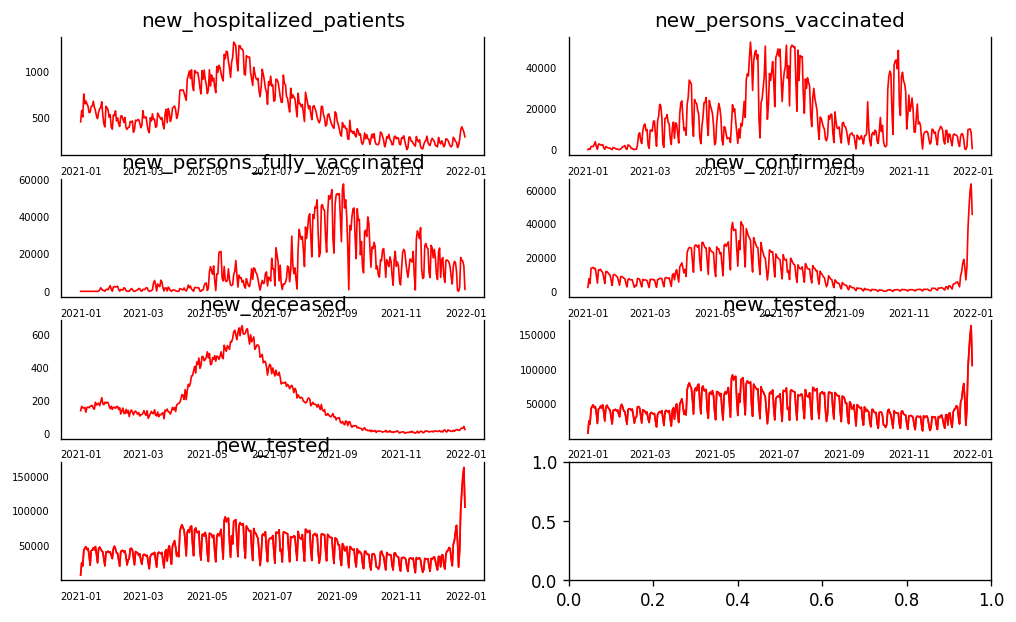

In [102]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_hosp_vacc_epi[df_hosp_vacc_epi.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_hosp_vacc_epi.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

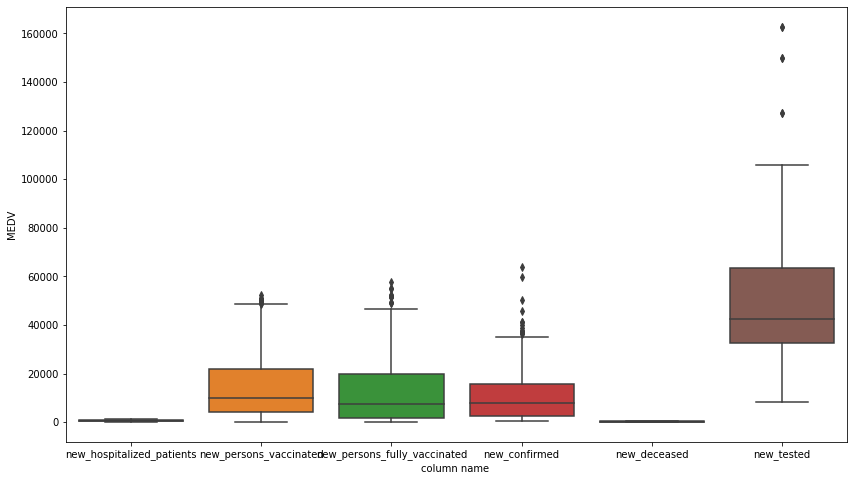

In [103]:
import seaborn as sns
import matplotlib.pyplot as ply
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(df_hosp_vacc_epi))
ax.set_xlabel('column name ')
ax.set_ylabel('MEDV')
plt.show()

In [104]:
# scaling the data




# from sklearn.preprocessing import StandardScaler


In [105]:
# before scaling the dataframe

df_hosp_vacc_epi.head(5)

,new_hospitalized_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_confirmed,new_deceased,new_tested,new_tested
Date,,,,,,,
2021-01-01,450,15,0,2684,140,8171,8171
2021-01-02,575,410,0,7766,166,25659,25659
2021-01-03,504,52,0,4934,157,21208,21208
2021-01-04,759,1465,1,13952,157,43432,43432
2021-01-05,650,1514,0,14083,160,46793,46793


In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_hosp_vacc_epi)
scaled_df= pd.DataFrame(X_scaled,columns=list(df_hosp_vacc_epi))

In [107]:
# after scaling the dataframe


scaled_df.head(5)

,new_hospitalized_patients,new_persons_vaccinated,new_persons_fully_vaccinated,new_confirmed,new_deceased,new_tested,new_tested
0,-0.368193,-1.084693,-0.912319,-0.795366,-0.304480,-1.841382,-1.841382
1,0.057708,-1.055978,-0.912319,-0.323178,-0.160852,-1.006166,-1.006166
2,-0.184204,-1.082003,-0.912319,-0.586310,-0.210569,-1.218743,-1.218743
3,0.684634,-0.979284,-0.912248,0.251586,-0.210569,-0.157338,-0.157338
4,0.313248,-0.975722,-0.912319,0.263758,-0.193997,0.003181,0.003181


In [89]:
# df_hosp_vacc_epi =scaled_df

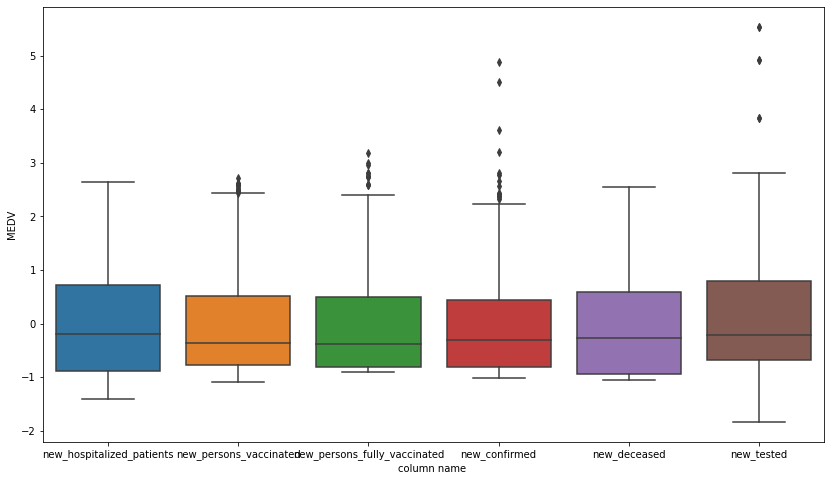

In [108]:
import seaborn as sns
import matplotlib.pyplot as ply
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(scaled_df))
ax.set_xlabel('column name ')
ax.set_ylabel('MEDV')
plt.show()

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

In [111]:
# performing augmented dicky fuller test to check the stationarity of the column new_hospitalized_patients

ad_fuller_result_1 = adfuller(df_hosp_vacc_epi['new_hospitalized_patients'].diff()[1:])

print('new_hospitalized_patients')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df_hosp_vacc_epi['new_persons_vaccinated'].diff()[1:])

print('new_persons_vaccinated')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')




# ad_fuller_result_1 = adfuller(scaled_df['new_hospitalized_patients'].diff()[1:])

# print('scaled  new_hospitalized_patients ')
# print(f'ADF Statistic: {ad_fuller_result_1[0]}')
# print(f'p-value: {ad_fuller_result_1[1]}')

# print('\n---------------------\n')

# ad_fuller_result_2 = adfuller(scaled_df['new_persons_vaccinated'].diff()[1:])

# print('scaled  new_persons_vaccinated')
# print(f'ADF Statistic: {ad_fuller_result_2[0]}')
# print(f'p-value: {ad_fuller_result_2[1]}')

new_hospitalized_patients
ADF Statistic: -2.9944866405893094
p-value: 0.03541249643539132

---------------------

new_persons_vaccinated
ADF Statistic: -4.9320772786507545
p-value: 3.019245943485067e-05


In [112]:
# checking the corelation of the columns using grangercausalitytests


print('new_hospitalized_patients causes new_persons_vaccinated?\n')
print('------------------')
granger_1 = grangercausalitytests(scaled_df[['new_persons_vaccinated', 'new_hospitalized_patients']], 4)
# 4 specifies the number of lags 
print('\n')
print('new_persons_vaccinated causes new_hospitalized_patients?\n')
print('------------------')
granger_2 = grangercausalitytests(scaled_df[['new_hospitalized_patients', 'new_persons_vaccinated']], 4)

new_hospitalized_patients causes new_persons_vaccinated?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8025  , p=0.0291  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=4.8424  , p=0.0278  , df=1
likelihood ratio test: chi2=4.8105  , p=0.0283  , df=1
parameter F test:         F=4.8025  , p=0.0291  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2347  , p=0.0008  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=14.6716 , p=0.0007  , df=2
likelihood ratio test: chi2=14.3828 , p=0.0008  , df=2
parameter F test:         F=7.2347  , p=0.0008  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9267  , p=0.0002  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=21.1898 , p=0.0001  , df=3
likelihood ratio test: chi2=20.5928 , p=0.0001  , df=3
parameter F test:         F=6.9267  , p=0.0002  , df_denom=355, df_num=3

Granger Causalit

In [123]:
# selcting the 2 columns to be predicted 

df_hosp_vacc_epi = df_hosp_vacc_epi[['new_hospitalized_patients', 'new_persons_vaccinated']]
print(df_hosp_vacc_epi.shape)

(365, 2)


In [126]:
# splitting the testing data and training data 
train_df=df_hosp_vacc_epi[:-10].astype('float32')
test_df =df_hosp_vacc_epi[-10:].astype('float32')


print(train_df.shape)
print(test_df.shape)



(355, 2)
(10, 2)


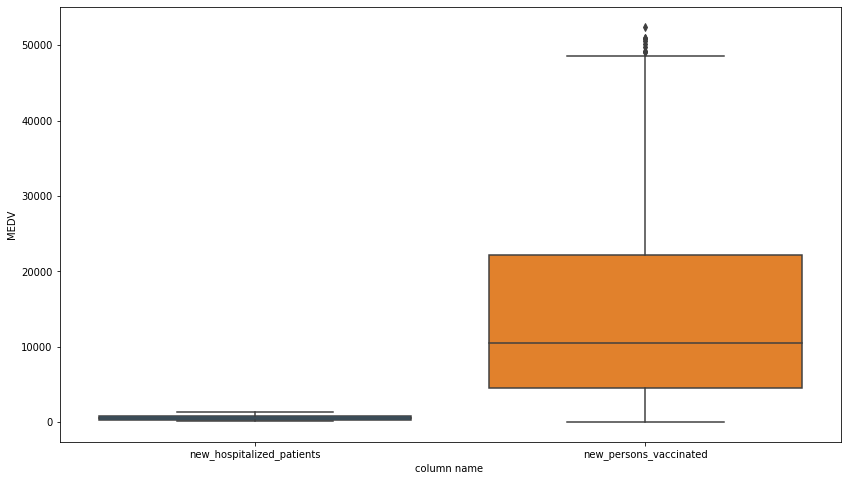

In [127]:
import seaborn as sns
import matplotlib.pyplot as ply
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(train_df))
ax.set_xlabel('column name ')
ax.set_ylabel('MEDV')
plt.show()

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df)
scaled_df= pd.DataFrame(X_scaled,columns=list(train_df))

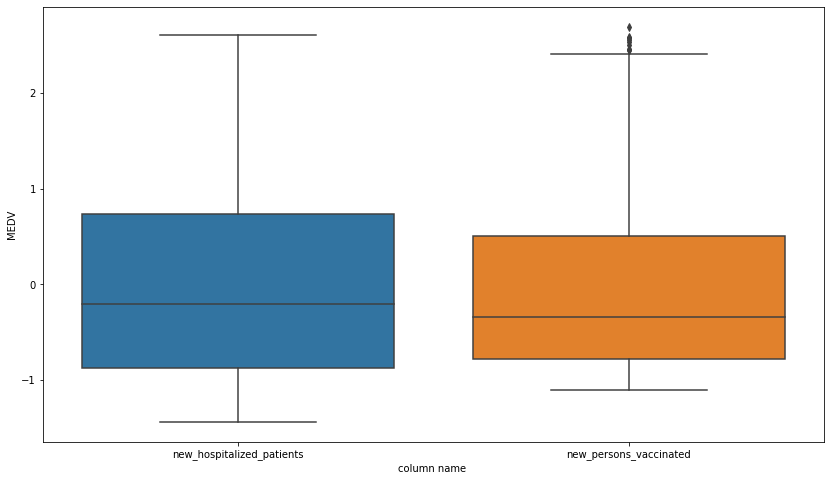

In [129]:
import seaborn as sns
import matplotlib.pyplot as ply
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.boxplot(x='variable', y='value', data=pd.melt(scaled_df))
ax.set_xlabel('column name ')
ax.set_ylabel('MEDV')
plt.show()

In [59]:
# import seaborn as sns
# import matplotlib.pyplot as ply
# fig, ax = plt.subplots(figsize=(14,8))
# ax = sns.boxplot(x='variable', y='value', data=pd.melt(X))
# ax.set_xlabel('')
# ax.set_ylabel('MEDV')
# plt.show()

In [130]:
model = VAR(scaled_df.diff()[1:])

In [61]:
# SIC (Schwarz information criterion, aka Bayesian information criterion BIC)
# AIC (Akaike information criterion)
# HQIC (Hannan-Quinn information criterion)


# The aim is to find the model with the lowest value of the selected information criterion. 

# ModelRisk applies these three criteria as a means of ranking each 
# fitted model, whether it be fitting a distribution, a time series model


sorted_order = model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.950      -3.927     0.01926      -3.941
1       -4.080      -4.011     0.01691      -4.052
2       -4.191      -4.077     0.01513      -4.145
3       -4.267      -4.107     0.01402      -4.203
4       -4.341      -4.136     0.01302      -4.259
5       -4.553      -4.302     0.01053      -4.453
6       -4.820      -4.523    0.008067      -4.702
7       -5.116     -4.774*    0.005999      -4.980
8       -5.151      -4.763    0.005793     -4.997*
9       -5.141      -4.707    0.005853      -4.968
10      -5.166      -4.687    0.005707      -4.975
11      -5.144      -4.619    0.005835      -4.935
12      -5.143      -4.572    0.005846      -4.915
13      -5.164      -4.548    0.005724      -4.918
14     -5.216*      -4.555   0.005432*      -4.952
15      -5.200      -4.493    0.005520      -4.918
16      -5.192      -4.439    0

In [141]:
# for varmax model we have to specify the auto regression and the movoing average (4- AR ,0- MA)


var_model = VARMAX(train_df, order=(5,0),enforce_stationarity= True)

# X = X.astype('float32')
# casting to float as the output will be in float and the program unable to convert float to int casting
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

C:\Users\slogeshkarthik\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                              Statespace Model Results                                             
Dep. Variable:     ['new_hospitalized_patients', 'new_persons_vaccinated']   No. Observations:                  355
Model:                                                              VAR(5)   Log Likelihood               -5608.184
                                                               + intercept   AIC                          11266.369
Date:                                                     Wed, 13 Apr 2022   BIC                          11363.172
Time:                                                             03:26:25   HQIC                         11304.879
Sample:                                                         01-01-2021                                         
                                                              - 12-21-2021                                         
Covariance Type:                                                       o

In [142]:
n_forecast = 10
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [143]:
predictions.columns=['pred_new_hospitalized_patients','pred_new_persons_vaccinated']

predictions
pd.DataFrame({"Actual":test_df['new_hospitalized_patients'],"Prediction":predictions['pred_new_hospitalized_patients']})

,Actual,Prediction
2021-12-22,233.0,253.278260
2021-12-23,225.0,232.358095
2021-12-24,166.0,223.535658
2021-12-25,188.0,237.390688
2021-12-26,254.0,247.851499
2021-12-27,359.0,255.486099
2021-12-28,396.0,254.613336
2021-12-29,368.0,251.001909
2021-12-30,336.0,249.805053
2021-12-31,284.0,251.611712


In [144]:
test_vs_pred = pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

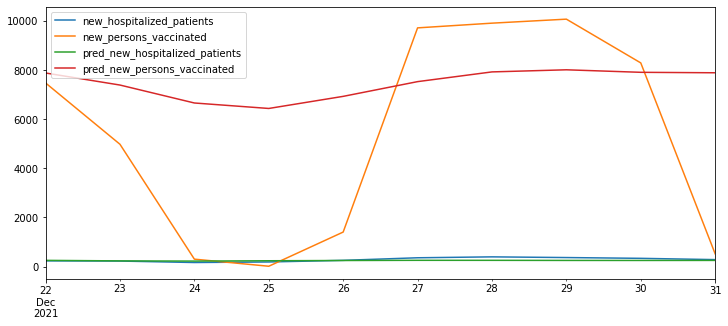

In [145]:
test_vs_pred.plot(figsize=(12,5))

In [149]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

# 'pred_new_hospitalized_patients','pred_new_persons_vaccinated'

rmse_ulc=math.sqrt(mean_squared_error(predictions['pred_new_hospitalized_patients'],test_df['new_hospitalized_patients']))
print('Mean value of hospitalized_patients is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['new_hospitalized_patients']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['pred_new_persons_vaccinated'],test_df['new_persons_vaccinated']))
print('Mean value of persons_vaccinated is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['new_persons_vaccinated']),rmse_rgnp))



# ['new_hospitalized_patients','new_persons_vaccinated']

Mean value of hospitalized_patients is : 280.9. Root Mean Squared Error is :76.89303298032061
Mean value of persons_vaccinated is : 5269.8. Root Mean Squared Error is :4309.507077074898
